In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import kronsum
from scipy.linalg import expm
from scipy.optimize import curve_fit
import pandas as pd

class NaV15Couple:
    
    """A couple of NaV1.5 channels"""
        
    T = np.arange(0, 4.01, 0.01)
    vh = -120
    V = np.arange(-100, 70, 5)
    NA = 6
    NB = 6
        
    def __init__(self, interaction):
        
        """
        
        Initialize the couple of NaV1.5 channels and set the interaction between them:
        
        0 - no interaction,
        1  - interaction I
        2 - interaction II
        
        """
                
        if interaction not in (0, 1, 2):
            raise ValueError('interaction must be either 0, 1 or 2')
        self._interaction = interaction
        
    def __repr__(self):
        if self.interaction == 0:
            return f'Two indipendently gating NaV1.5 channels'
        elif self.interaction == 1:
            return f'Two NaV1.5 channels with interaction I'
        else:
            return f'Two NaV1.5 channels with interaction II'
        
    @property
    def interaction(self):
        return self._interaction
    
        
    def change_statesI():
    
        """Obtain the list of compound states changed in interaction I and II"""

        states = ['C3', 'C2', 'C1', 'O', 'IF', 'IS']
        statesA = states[:3]
        statesB = states[3]
        ch_states = []
        for i in statesA:
            for j in statesB:
                ch_states.append(i+j)
                ch_states.append(j+i)
        
        return ch_states
    
    change_statesI = change_statesI()
    

    def change_barrsI():

        """Obtain the list of tuples of compound states for changed barriers in interaction I"""

        ch_barrs = [('C3O', 'C2O'), ('C2O', 'C1O'), ('C1O', 'OO'), ('OO', 'OC1'), ('OC1', 'OC2'), ('OC2', 'OC3')]
        
        return ch_barrs
    
    change_barrsI = change_barrsI()
    
    def change_barrsII():

        """Obtain the list of tuples of compound states for changed barriers in interaction I"""

        ch_barrs = [('C1IF', 'C1O'), ('C1O', 'OO'), ('OIF', 'OO'), ('OO', 'IFO'), ('OO', 'OC1'), ('OC1', 'IFC1')]
        kT = [-1, -2, 2, 2, -2, -1]
        ch_barrs_kT = list(zip(ch_barrs, kT))
        
        return ch_barrs_kT
    
    change_barrsII = change_barrsII()
        
    def Q(self, v):
    
        """Construct transition rate matrix of compound states 
        and change energies of states and barriers in case of interactions (interaction = 1 or interaction 2)"""

        a11 = 3.802/(0.1027*np.exp(-v/17) + 0.2*np.exp(-v/150)) #rc3c2
        a12 = 3.802/(0.1027*np.exp(-v/15) + 0.23*np.exp(-v/150)) #rc2c1
        a13 = 3.802/(0.1027*np.exp(-v/12) + 0.25*np.exp(-v/150)) #rc1o

        b11 = 0.1917*np.exp(-v/20.3) #rc2c3
        b12 = 0.2*np.exp(-(v-5)/20.3) #rc1c2 
        b13 = 0.22*np.exp(-(v-10)/20.3)#roc1 

        a2 = 9.178*np.exp(v/29.68) #roif
        a3 = 3.7933*10**-10 * np.exp(-v/5.2) #rifc1 

        b3 = 0.0084 + 0.00002 * v #rc1if
        b2 = (a13 * a2 * a3)/(b13 * b3) #rifo
        a4 = a2/100
        b4 = a3      

        Q = np.zeros((6, 6))

        Q[0, 1] = b11
        Q[1, 0], Q[1, 2] = a11, b12
        Q[2, 1], Q[2, 3], Q[2, 4] = a12, b13, a3
        Q[3, 2], Q[3, 4] = a13, b2
        Q[4, 2], Q[4, 3], Q[4, 5] = b3, a2, b4
        Q[5, 4] = a4
        for i in range(6):
            Q[i, i] = -(Q[:i , i].sum() + Q[i+1: , i].sum())

        #composed states transition matrix defentition

        Q_AB = kronsum(Q, Q).todense()
        for i in range(Q_AB.shape[0]):
            Q_AB[i, i] = -(Q_AB[:i, i].sum() + Q_AB[i+1:, i].sum())
            
        interaction = self.interaction

        if interaction == 0:
            
            return Q_AB

        elif interaction == 1:
            states = ['C3', 'C2', 'C1', 'O', 'IF', 'IS']
            n = int(Q_AB.shape[0]**0.5)
            statesA = np.array([[i]*n for i in states]).ravel()
            statesB = np.array(states*n)
            statesA_B = [i+j for i, j in zip(statesA, statesB)]
            DF = pd.DataFrame(data=Q_AB, index=statesA_B, columns=statesA_B)
            ch_states = self.change_statesI
            ch_barrs = self.change_barrsI
            E_st = 2
            E_barr = -2

            for st in ch_states:
                DF.loc[:, st] *= np.exp(E_st)

            for barr in ch_barrs:
                DF.at[barr[0], barr[1]] *= np.exp(-E_barr)
                DF.at[barr[1], barr[0]] *= np.exp(-E_barr)

            Q_AB = DF.to_numpy()
            for i in range(Q_AB.shape[0]):
                Q_AB[i, i] = -(Q_AB[:i, i].sum() + Q_AB[i+1:, i].sum())
            
            return Q_AB
              

        elif interaction == 2:
            states = ['C3', 'C2', 'C1', 'O', 'IF', 'IS']
            n = int(Q_AB.shape[0]**0.5)
            statesA = np.array([[i]*n for i in states]).ravel()
            statesB = np.array(states*n)
            statesA_B = [i+j for i, j in zip(statesA, statesB)]
            DF = pd.DataFrame(data=Q_AB, index=statesA_B, columns=statesA_B)
            ch_states = self.change_statesI
            E_st = 2
            ch_barrs_and_kT = self.change_barrsII

            for st in ch_states:
                DF.loc[:, st] *= np.exp(E_st)

            for barr, E_barr in ch_barrs_and_kT:
                DF.at[barr[0], barr[1]] *= np.exp(-E_barr)
                DF.at[barr[1], barr[0]] *= np.exp(-E_barr)

            Q_AB = DF.to_numpy()
            for i in range(Q_AB.shape[0]):
                Q_AB[i, i] = -(Q_AB[:i, i].sum() + Q_AB[i+1:, i].sum())
            
            return Q_AB 
     
      
    def find_SS(self):
    
        """Find steady state (SS) probaility vector"""
        vh = self.vh
        Q_matrix = self.Q(vh)
        Q_matrix[0,:] = np.ones(Q_matrix.shape[1])
        zero = np.zeros((Q_matrix.shape[0], 1))
        zero[0,0] = 1
        ss = np.linalg.solve(Q_matrix, zero)
        
        return ss
    
        
    def determ_sim_P(self, v):
    
        """Calculate P vector of the compound states. This is the maine deterministic simulation function"""
        
        v = v
        Q_matrix = self.Q(v)
        p0 = self.find_SS()
        P = np.zeros((Q_matrix.shape[0], 1))
        T = self.T

        for t in T:
            p = expm(t*Q_matrix).dot(p0)
            P = np.hstack((P, p))
        P = np.delete(P, 0, axis=1)
        
        return P
    
    def determ_sim_Po(self, v):
    
        """Retrive Po of channel A and channnel B from probabolity vector of compound states"""

        v = v
        T = self.T
        P = self.determ_sim_P(v)
        NA = self.NA
        NB = self.NB
        O_A = np.kron(np.identity(NA), np.ones(NB))
        O_B = np.kron(np.ones(NA), np.identity(NB))
        PA = np.zeros(NA)
        PB = np.zeros(NB)

        for i in range(len(T)):
            pA = O_A.dot(P[:,i])
            PA = np.vstack((PA, pA))

        PA = np.delete(PA, 0, axis=0)

        for i in range(len(T)):
            pB = O_B.dot(P[:,i])
            PB = np.vstack((PB, pB))

        PB = np.delete(PB, 0, axis=0)

        return np.array([PA.T[3], PB.T[3]])
    
    def determ_sim_I(self, v):
    
        """Calculate ensemble average currents of a couple of channels"""

        vh = self.vh
        v = v
        v_rev = 70
        g = 15
        ich = 0.001*g*(v - v_rev)
        po_A, po_B = self.determ_sim_Po(v)
        I_ens_av = ich*po_A + ich*po_B
        
        return I_ens_av
               
        
    def determ_sim_f(self, v):

        """ Calculate f0, f1, f2 and there expected velues (f0_1, f1_i, f_i) for two identical channels"""

        T = self.T
        vh = self.vh
        v = v
        Q_matrix = self.Q(v)
        
        P = self.determ_sim_P(v)
        states = ['C3', 'C2', 'C1', 'O', 'IF', 'IS']
        n = int(Q_matrix.shape[0]**0.5)
        statesA = np.array([[i]*n for i in states]).ravel()
        statesB = np.array(states*n)
        statesA_B = [i+j for i, j in zip(statesA, statesB)]
        f0_states = [i for i in statesA_B if 'O' not in i]
        f1_states = [i for i in statesA_B if 'O' in i]
        f1_states.remove('OO')
        f2_states = ['OO']
        DF = pd.DataFrame(data=P, index=statesA_B)
        F0 = np.zeros(1)
        F1 = np.zeros(1)
        F2 = np.zeros(1)
        for n in range(T.size):
            f0 = DF.loc[f0_states, n].sum(axis=0)
            F0 = np.hstack((F0, f0))
        F0 = np.delete(F0, 0, axis=0)
        for n in range(T.size):
            f1 = DF.loc[f1_states, n].sum(axis=0)
            F1 = np.hstack((F1, f1))
        F1 = np.delete(F1, 0, axis=0)
        for n in range(T.size):
            f2 = DF.loc[f2_states, n].sum(axis=0)
            F2 = np.hstack((F2, f2))
        F2 = np.delete(F2, 0, axis=0)

        F0_i = np.power((F0+F1/2), 2)
        F1_i = 2*(F1/2 + F2)*(F0 +F1/2)
        F2_i = np.power((F1/2 + F2), 2)
        
        return F1, F1_i, F2, F2_i
    
    def integral_peak_INa(self):
        
        """Simulate peak INa voltage protocol and calculate I-V curve and G/Gms of peak INa"""
    
        t = self.T
        vh = self.vh
        V = self.V
        v_rev = 70
        I = np.zeros(t.size)
        for v in V:
            i = self.determ_sim_I(v)
            I = np.vstack((I, i))
        I = np.delete(I, 0, axis=0)
        peaks = np.array([])
        G = np.array([])
        for sweep in range(I.shape[0]):
            peak = I[sweep].min()
            peaks = np.append(peaks, peak)
        for potential in V[V<10]:
            g = peaks[np.where(V==potential)[0][0]]/(potential - v_rev)
            G = np.append(G, g)
        G_max = G.max()
        G /=G_max
        return V, peaks, V[V<10], G

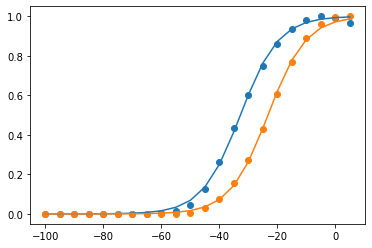

In [2]:
Ch2_non_int = NaV15Couple(0)
Ch2_int_I = NaV15Couple(1)
Ch2_int_II = NaV15Couple(2)
Vg, G_non = Ch2_non_int.integral_peak_INa()[2:]
Vg, G_int_I = Ch2_int_I.integral_peak_INa()[2:]
Vg, G_int_II = Ch2_int_II.integral_peak_INa()[2:]

def Boltzmann_sigm(x, Vhalf, k):
    return 1/(1+np.exp((Vhalf-x)/k))

popt_non, pcov= curve_fit(Boltzmann_sigm, Vg, G_non, [-40, 2.5])
popt_int_I, pcov= curve_fit(Boltzmann_sigm, Vg, G_int_I)
popt_int_II, pcov= curve_fit(Boltzmann_sigm, Vg, G_int_II)

fit_line_non = Boltzmann_sigm(Vg, popt_non[0], popt_non[1])
fit_line_int_I = Boltzmann_sigm(Vg, popt_int_I[0], popt_int_I[1])
fit_line_int_II = Boltzmann_sigm(Vg, popt_int_II[0], popt_int_II[1])

plt.scatter(Vg, G_non)
plt.plot(Vg, fit_line_non)
plt.scatter(Vg, G_int_II)
plt.plot(Vg, fit_line_int_II)

In [18]:
Ch2_non_int.determ_sim_I(-20)
Ch2_int_II.determ_sim_I(-20)
Ch2_int_I.determ_sim_f(-20)
Ch2_int_II.determ_sim_f(-20)

NameError: name 'determ_sim_P' is not defined

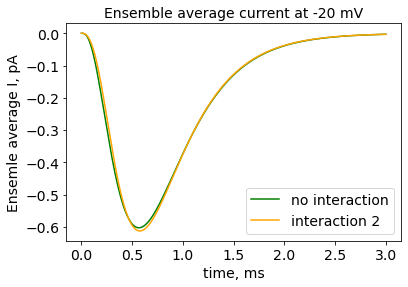

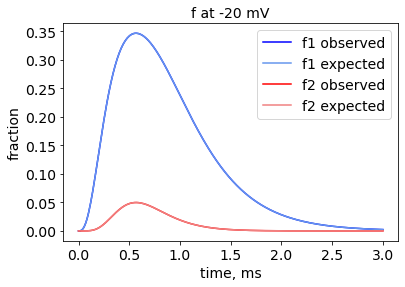

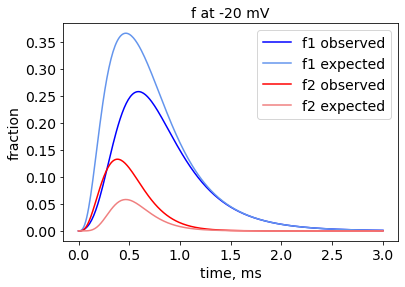

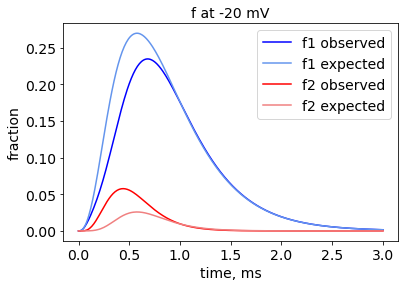

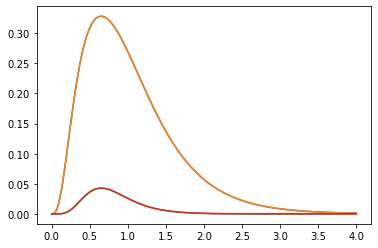

In [16]:
import os
os.chdir(r'C:\Single_channel_analysis')
t = NaV15Couple(0).T
two_ch = NaV15Couple(0)
v_test = -23
f1, f1_, f2, f2_ = two_ch.determ_sim_f(v_test)
plt.plot(t, f1)
plt.plot(t, f1_)
plt.plot(t, f2)
plt.plot(t, f2_)
pd.DataFrame(data=[t, f1,f1_, f2, f2_]).T.to_csv(f'NaV1.5_non_int_f1f2_{v_test}.csv', header = [_ + ' model 0' for _ in ('t','f1','f1_', 'f2', 'f2_')],index=False)

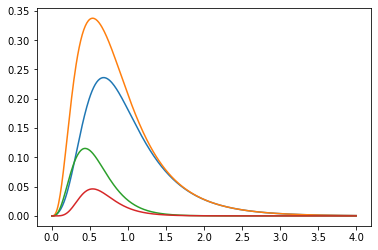

In [18]:
import os
os.chdir(r'C:\Single_channel_analysis')
two_ch = NaV15Couple(1)
t = two_ch.T
v_test = -23
f1, f1_, f2, f2_ = two_ch.determ_sim_f(v_test)
plt.plot(t, f1)
plt.plot(t, f1_)
plt.plot(t, f2)
plt.plot(t, f2_)
pd.DataFrame(data=[t, f1,f1_, f2, f2_]).T.to_csv(f'NaV1.5_int_I_f1f2_{v_test}.csv', header = [_ + ' model 1' for _ in ('t','f1','f1_', 'f2', 'f2_')],index=False)

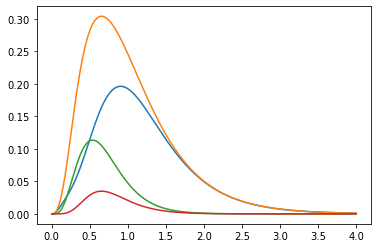

In [19]:
import os
os.chdir(r'C:\Single_channel_analysis')
two_ch = NaV15Couple(2)
t = two_ch.T
v_test = -23
f1, f1_, f2, f2_ = two_ch.determ_sim_f(v_test)
plt.plot(t, f1)
plt.plot(t, f1_)
plt.plot(t, f2)
plt.plot(t, f2_)
pd.DataFrame(data=[t, f1,f1_, f2, f2_]).T.to_csv(f'NaV1.5_int_II_f1f2_{v_test}.csv', header = [_ + ' model 1' for _ in ('t','f1','f1_', 'f2', 'f2_')],index=False)